In [2]:
from tensorflow.keras import backend as K
K.clear_session()

!pip install rarfile

import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image
# Download the RAR file
url = 'https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ'
output_rar = '/content/drive/MyDrive/My_Dataset_CT-Scan-augumentated.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From (original): https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ
From (redirected): https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ&confirm=t&uuid=2d067b52-9339-4349-ab08-5198e1aaeacc
To: /content/drive/MyDrive/My_Dataset_CT-Scan-augumentated.rar
100%|██████████| 80.1M/80.1M [00:01<00:00, 49.6MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the extracted dataset folder

dataset = '/content/My_Dataset_CT-Scan-augumentated'

In [4]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    classes=3
    outputs = Dense(classes, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 3835 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
Found 1105 images belonging to 3 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 127s 569ms/step - accuracy: 0.6141 - loss: 0.8856 - val_accuracy: 0.5138 - val_loss: 1.6378
Epoch 2/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 79s 297ms/step - accuracy: 0.8156 - loss: 0.4901 - val_accuracy: 0.3817 - val_loss: 2.8456
Epoch 3/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.8917 - loss: 0.3031 - val_accuracy: 0.3761 - val_loss: 6.7037
Epoch 4/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 302ms/step - accuracy: 0.9468 - loss: 0.1418 - val_accuracy: 0.5615 - val_loss: 3.8065
Epoch 5/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 37s 303ms/step - accuracy: 0.9596 - loss: 0.1221 - val_accuracy: 0.5761 - val_loss: 5.6849
Epoch 6/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 42s 312ms/step - accuracy: 0.9676 - loss: 0.1029 - val_accuracy: 0.7927 - val_loss: 0.9245
Epoch 7/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.9911 - loss: 0.0295 - val_accuracy: 0.9376 - val_loss: 0.1835
Epoch 8/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 41s 304ms/step - accuracy: 0.9843 - loss: 0.0478 - va

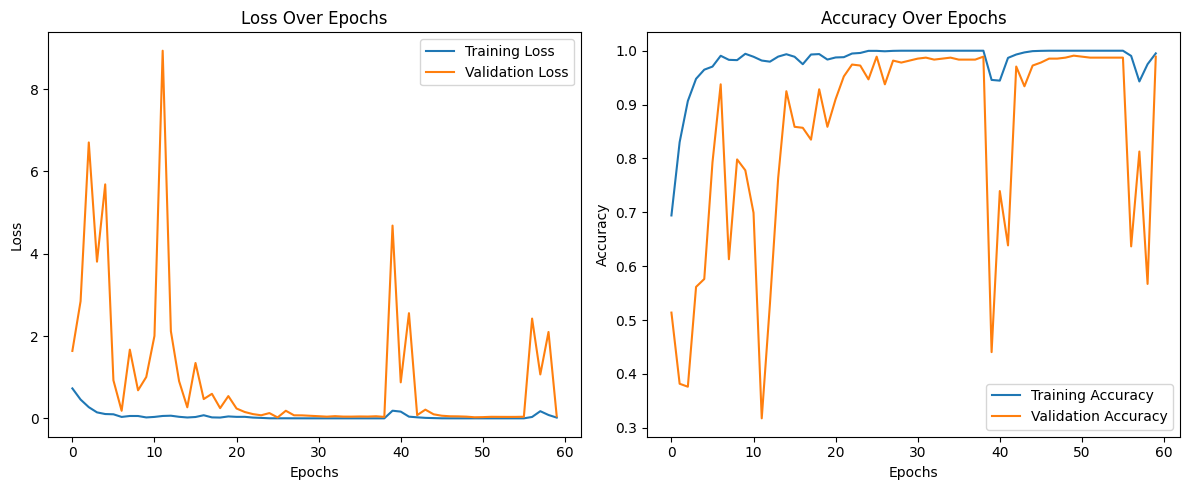

35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step

Performance on Test Data [Using ResNet-ReLu]
Precision: 0.985603869112171
Recall: 0.9855203619909503
F1 Score: 0.9855023009817481
Accuracy: 0.9855203619909503
Confusion Matrix:
                  Bengin cases  Malignant cases  Normal cases
Bengin cases              113                6             1
Malignant cases             0              565             0
Normal cases                7                2           411


In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
    GlobalAveragePooling2D, Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Directory for the dataset
data_dir = dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=60, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['Bengin cases','Malignant cases','Normal cases'], title="Performance on Test Data [Using ResNet-ReLu]")


In [6]:
from tensorflow.keras import backend as K
K.clear_session()

from google.colab import drive
drive.mount('/content/drive')

!pip install rarfile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image
# Download the RAR file
url = 'https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ'
output_rar = '/content/drive/MyDrive/My_Dataset_CT-Scan-augumentated.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From (original): https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ
From (redirected): https://drive.google.com/uc?id=1tm8ZsBG5sYcZjFJRB8nVkmzABbbLvvcQ&confirm=t&uuid=7198bd2c-281a-49b2-9bb1-91d1c4aa3bde
To: /content/drive/MyDrive/My_Dataset_CT-Scan-augumentated.rar
100%|██████████| 80.1M/80.1M [00:00<00:00, 108MB/s]


In [8]:
dataset = '//content/My_Dataset_CT-Scan-augumentated'

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,714 (16.36 MB)

 Trainable params: 1,059,850 (4.04 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

Found 3835 images belonging to 3 classes.
Found 545 images belonging to 3 classes.
Found 1105 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.7608 - loss: 0.6758 - val_accuracy: 0.8679 - val_loss: 0.3384
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8937 - loss: 0.2708 - val_accuracy: 0.8679 - val_loss: 0.3268
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8952 - loss: 0.2556 - val_accuracy: 0.9028 - val_loss: 0.2426
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.9395 - loss: 0.1755 - val_accuracy: 0.9174 - val_loss: 0.2267
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.9604 - loss: 0.1398 - val_accuracy: 0.9119 - val_loss: 0.2277
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9671 - loss: 0.1203 - val_accuracy: 0.9413 - val_loss: 0.1941
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.9787 - loss: 0.0937 - val_accuracy: 0.9431 - val_loss: 0.1772
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.9833 - loss: 0.0825 - val_accuracy: 

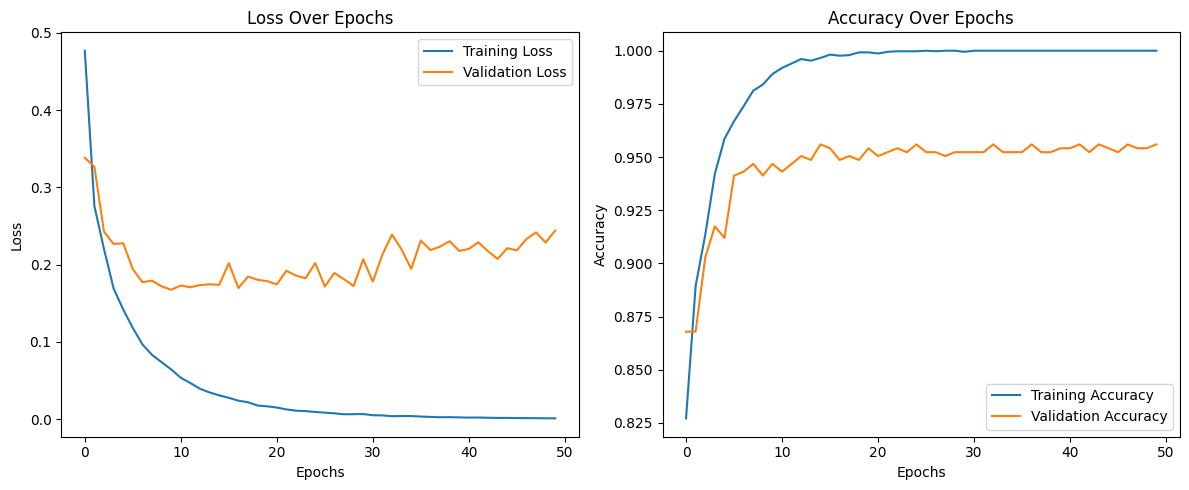

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step

Performance Test Using Mobile Net
Precision: 0.9676018099547512
Recall: 0.9665158371040724
F1 Score: 0.9647504625192252
Accuracy: 0.9665158371040724
Confusion Matrix:
                  Bengin cases  Malignant cases  Normal cases
Bengin cases               87                1            32
Malignant cases             0              564             1
Normal cases                3                0           417


In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Directory for the dataset
data_dir = dataset

# Load MobileNet with pre-trained ImageNet weights, excluding the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model to prevent training them
base_model.trainable = False

# Add custom layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)  # Adjust the number of classes as needed

# Create the model
model = Model(inputs, outputs)

# Print the model summary
model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=50, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['Bengin cases', 'Malignant cases', 'Normal cases'], title="Performance Test Using Mobile Net")